In [1]:

import math
import time
from typing import Optional, Tuple, List
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image



# Attention Mechanisms and Transformers

CNNs, with their inductive biases of locality and translation invariance, dominated vision tasks for decades, from LeNet to modern ResNets. This changed with the advent of Vision Transformers, which surpassed CNNs in accuracy despite having weaker built-in biases.    

While some Transformer advances can be adapted for CNNs, this usually comes at higher computational cost, and recent hardware optimizations have further favored Transformers. Their success is largely due to massive image datasets, which enabled models to learn structure directly from data. Today, Vision Transformers set the state of the art in large-scale image classification, showing that scalability and self-attention can outweigh carefully designed inductive biases.

Actually, we are witnessing a shift in all fields as Transformers have displaced earlier models across nearly every domain. In natural language processing, pretrained Transformer models such as BERT, RoBERTa, and GPT have become the default starting point, fine-tuned for nearly all downstream tasks, while similar architectures are spreading to speech, reinforcement learning, and graph data. 

The key innovation is the **attention mechanism**, which allows models to focus dynamically on relevant parts of the input rather than compressing sequences into fixed vectors. First introduced as an enhancement to RNNs, attention proved so powerful that Vaswani et al. (2017) replaced recurrence entirely, giving rise to the Transformer. Its combination with large-scale pretraining on massive corpora created a decisive performance gap over traditional architectures, ushering in the era of foundation models—large, general-purpose networks adapted to specific tasks through fine-tuning.

## Queries, Keys, and Values

Most neural networks traditionally assume inputs of fixed size—for instance, images with a given resolution. This assumption breaks down when inputs are long or variable in length, such as in machine translation, where it is difficult to compress all relevant information into a single vector without losing detail.

The **attention mechanism** solves this problem by treating the input as a set of **key–value pairs** and introducing a **query** that retrieves relevant information. Conceptually, this is similar to a database lookup: keys act as identifiers, values store content, and a query retrieves the most relevant values. But instead of returning just one match, attention computes a weighted combination of all values:

$$
\text{Attention}(\mathbf{q}, \mathcal{D}) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i)\,\mathbf{v}_i ,
$$

where each weight $\alpha(\mathbf{q}, \mathbf{k}_i)$ measures how strongly key $\mathbf{k}_i$ matches the query $\mathbf{q}$. Normalizing the weights with a softmax ensures they are nonnegative and sum to 1, turning them into a probability distribution that can be interpreted (cautiously) as “relative importance.” This allows attention to cover several useful cases: exact matching (one weight = 1), averaging (all weights equal), or soft combinations of relevant elements. The key strengths of attention are that it is differentiable, scalable to large inputs, and parameter-efficient, making it possible for a model to “focus” flexibly without compressing everything into a fixed-length bottleneck.

![QKV](./images/transformers/attention.png)

### The Scoring Function

A common strategy for ensuring that the weights sum up to 1 is to normalize them via

$$ \alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{q}, \mathbf{k}_j)}. $$

In particular, to ensure that the weights are also nonnegative, one can resort to exponentiation. This means that we can now pick *any* **scoring function**
$a(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it via

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))}.
$$

Several important forms of $a$ are commonly used:

* **Dot-product attention**

  $$
  a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i .
  $$

  This is the simplest form, where similarity is defined by the inner product between the two vectors. Queries and keys that point in the same direction yield large positive scores, while orthogonal or opposing vectors yield low or negative scores. This formulation is efficient because it reduces to matrix multiplication when many queries and keys are processed in parallel.

* **Scaled dot-product attention**

  $$
  a(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}} ,
  $$

  where $d$ is the dimension of the vectors. When $d$ is large, the raw dot product can become large in magnitude, leading the softmax to produce extremely sharp distributions with vanishing gradients. Dividing by $\sqrt{d}$ counteracts this effect, keeping the scores in a range that allows stable training. This is the form used in the Transformer architecture.

* **Additive (Bahdanau) attention**

  $$
  a(\mathbf{q}, \mathbf{k}_i) = \mathbf{w}^\top \tanh(W_q \mathbf{q} + W_k \mathbf{k}_i) ,
  $$

  where $W_q$ and $W_k$ are learnable projection matrices and $\mathbf{w}$ is a learnable vector. Instead of comparing queries and keys directly, they are first mapped into a joint space and combined through a nonlinear transformation. The tanh introduces nonlinearity, allowing the network to learn complex relationships beyond linear similarity. This formulation is more flexible but typically more computationally expensive than dot-product attention.

* **Bilinear attention**

  $$
  a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top W \mathbf{k}_i ,
  $$

  where $W$ is a learnable weight matrix. This generalizes the dot product by allowing a linear transformation of the keys before comparison, giving the model additional capacity to learn task-specific notions of similarity.

* **General forms**
  In principle, any differentiable function can serve as $a$, as long as it outputs scalar scores that can be exponentiated and normalized. This could include deeper neural networks, kernel functions, or task-specific similarity measures.

>Each formulation of $a$ represents a different way of measuring relevance, trading off computational cost, expressiveness, and stability. The choice of scoring function is critical to the behavior and effectiveness of the attention mechanism.


To better understand how different scoring functions shape the attention mechanism, let’s construct a small example with just two queries and three keys. Each query and key is represented as a 4-dimensional vector. By applying different scoring functions—dot product, scaled dot product, additive (Bahdanau), and bilinear—we can compute attention scores, normalize them with a softmax to obtain weights, and visualize the resulting distributions as heatmaps. These plots show how each query attends differently to the available keys depending on the chosen similarity measure.

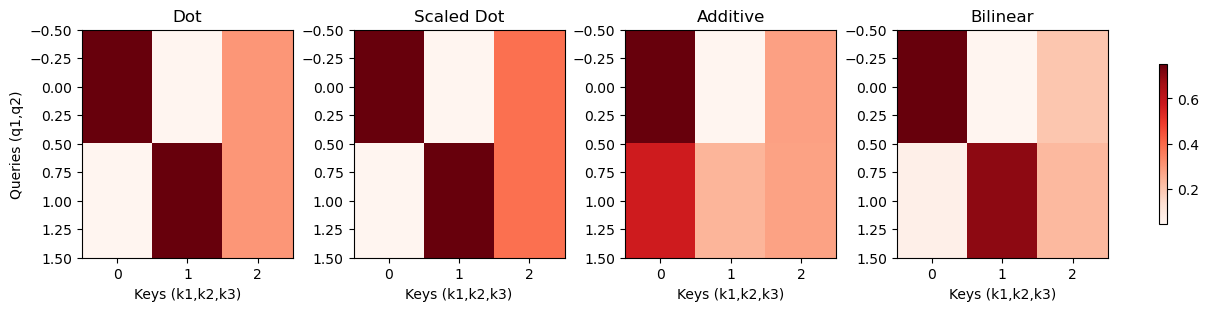

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, cmap='Reds'):
    A = np.array(matrices)
    num_rows, num_cols, _, _ = A.shape
    
    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize=(3*num_cols, 3*num_rows),
        squeeze=False,
        constrained_layout=True
    )

    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            im = ax.imshow(A[i, j], cmap=cmap, aspect='auto')
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles and i == 0:
                ax.set_title(titles[j])

    # single shared colorbar, positioned on the right
    fig.colorbar(im, ax=axes, shrink=0.7, location='right')
    plt.show()


# Toy example 
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

rng = np.random.default_rng(0)
d = 4
Q = np.array([[1.0, 0.0, 0.5, -0.5],
              [0.0, 1.0, -0.5, 0.5]])
K = np.array([[1.0, 0.0, 0.5, -0.5],
              [0.0, 1.0, -0.5, 0.5],
              [0.7, 0.7, 0.0, 0.0]])

def scores_dot(Q, K): return Q @ K.T
def scores_scaled_dot(Q, K): return (Q @ K.T) / np.sqrt(Q.shape[1])
def scores_additive(Q, K, dh=8):
    W_q = rng.normal(scale=0.5, size=(dh, Q.shape[1]))
    W_k = rng.normal(scale=0.5, size=(dh, K.shape[1]))
    w   = rng.normal(scale=0.5, size=(dh,))
    Qp = (W_q @ Q.T).T
    Kp = (W_k @ K.T).T
    H  = np.tanh(Qp[:, None, :] + Kp[None, :, :])
    return H @ w
def scores_bilinear(Q, K):
    W = rng.normal(scale=0.4, size=(Q.shape[1], K.shape[1]))
    return Q @ W @ K.T

A_dot   = softmax(scores_dot(Q, K), axis=1)
A_sdot  = softmax(scores_scaled_dot(Q, K), axis=1)
A_add   = softmax(scores_additive(Q, K), axis=1)
A_bilin = softmax(scores_bilinear(Q, K), axis=1)

mats = np.stack([A_dot, A_sdot, A_add, A_bilin], axis=0)[None, ...]
titles = ["Dot", "Scaled Dot", "Additive", "Bilinear"]

show_heatmaps(mats, xlabel="Keys (k1,k2,k3)", ylabel="Queries (q1,q2)", titles=titles)


The heatmaps reveal how the choice of scoring function changes the distribution of attention. For example, with the dot product and scaled dot product, each query tends to assign high weight to the key that is most similar in direction, producing a sharp focus. The scaling mainly prevents the distribution from becoming overly peaked when vector dimensions grow. Additive attention often yields softer distributions because the learned nonlinear comparison can balance contributions from multiple keys. Bilinear attention generalizes the dot product and can shift weights depending on the learned transformation, sometimes favoring keys that would not dominate under a raw dot product.

## Multi-Head Attention

A single attention mechanism can only capture one type of dependency between queries, keys, and values. In practice, however, we often want to model different types of relationships simultaneously—for example, short-range vs. long-range dependencies in a sequence. To achieve this, **multi-head attention** projects queries, keys, and values into multiple representation subspaces and applies attention in parallel.

Formally, given query $\mathbf{q}\in\mathbb{R}^{d_q}$, key $\mathbf{k}\in\mathbb{R}^{d_k}$, and value $\mathbf{v}\in\mathbb{R}^{d_v}$, each head $\mathbf{h}_i$ ($i=1,\dots,h$) is computed as

$$
\mathbf{h}_i = f(\mathbf{W}_i^{(q)}\mathbf{q}, \; \mathbf{W}_i^{(k)}\mathbf{k}, \; \mathbf{W}_i^{(v)}\mathbf{v}) \in \mathbb{R}^{p_v},
$$

where $\mathbf{W}_i^{(q)} \in \mathbb{R}^{p_q \times d_q}$,
$\mathbf{W}_i^{(k)} \in \mathbb{R}^{p_k \times d_k}$, and
$\mathbf{W}_i^{(v)} \in \mathbb{R}^{p_v \times d_v}$ are learned projections and $f$ is an attention function (e.g., scaled dot-product).

The outputs of all $h$ heads are concatenated and mapped to the final output dimension $p_o$ via

$$
\mathbf{W}_o 
\begin{bmatrix}
\mathbf{h}_1 \\ \vdots \\ \mathbf{h}_h
\end{bmatrix}
\in \mathbb{R}^{p_o},
$$

with $\mathbf{W}_o \in \mathbb{R}^{p_o \times hp_v}$.

This way, each head can thus focus on different aspects of the input, enabling the model to represent richer relationships than a single attention mechanism.


In practice, to keep computation manageable, we set
$p_q = p_k = p_v = p_o/h$. This ensures that each head has reduced dimensionality, while their concatenation preserves the overall model size. Heads can be computed in parallel by projecting queries, keys, and values into $hp_q, hp_k, hp_v$ dimensions, then splitting them across heads.


To build intuition for multi-head attention, we construct a simple example
with two queries (q1, q2) and four keys (k1–k4). The feature space is split
into two halves, so that each attention head operates on a different
subspace:

* Head 1: focuses on the first three dimensions.
* Head 2: focuses on the last three dimensions.

Queries and keys are hand-crafted so that q1 aligns with the first half
(k1,k2) and q2 aligns with the second half (k3,k4). By visualizing the
attention weights, we can see how each head learns to specialize.

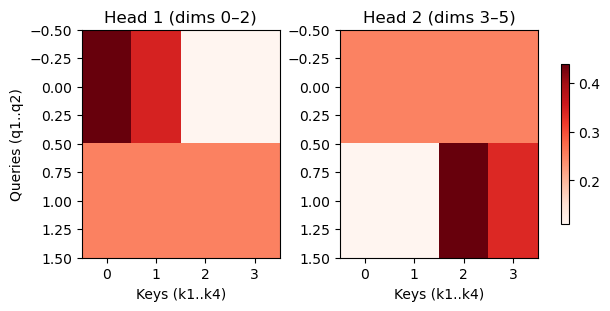

In [3]:
"""
Toy Example: Multi-Head Attention Heatmaps
"""

import numpy as np
import matplotlib.pyplot as plt

def show_heatmaps(matrices, xlabel, ylabel, titles=None, cmap='Reds'):
    A = np.array(matrices)
    num_rows, num_cols, _, _ = A.shape
    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(3*num_cols, 3*num_rows),
                             squeeze=False,
                             constrained_layout=True)
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            im = ax.imshow(A[i, j], cmap=cmap, aspect='auto')
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles and i == 0:
                ax.set_title(titles[j])
    fig.colorbar(im, ax=axes, shrink=0.7, location='right')
    plt.show()

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

# Define queries and keys
d_model = 6
h       = 2
d_h     = d_model // h

Q = np.array([
    [1.0, 0.9, 0.8, 0.0, 0.0, 0.0],  # q1: first half active
    [0.0, 0.0, 0.0, 1.0, 0.9, 0.8],  # q2: second half active
])
K = np.array([
    [1.0, 0.8, 0.7, 0.0, 0.0, 0.0],  # k1: first half
    [0.85, 0.6, 0.6, 0.0, 0.0, 0.0], # k2: first half
    [0.0, 0.0, 0.0, 1.0, 0.9, 0.7],  # k3: second half
    [0.0, 0.0, 0.0, 0.85, 0.65, 0.6] # k4: second half
])

# Split into heads
Q_h1, Q_h2 = Q[:, 0:3], Q[:, 3:6]
K_h1, K_h2 = K[:, 0:3], K[:, 3:6]

scale = 1 / np.sqrt(d_h)
S1 = (Q_h1 @ K_h1.T) * scale
S2 = (Q_h2 @ K_h2.T) * scale

A1 = softmax(S1, axis=1)
A2 = softmax(S2, axis=1)

# Visualize
mats = np.stack([A1, A2], axis=0)[None, ...]
titles = ["Head 1 (dims 0–2)", "Head 2 (dims 3–5)"]
show_heatmaps(mats, xlabel="Keys (k1..k4)", ylabel="Queries (q1..q2)", titles=titles)


The heatmaps clearly show that:

* Head 1 assigns high attention weights from q1 to k1 and k2, since they share
  strong features in the first three dimensions. q2, however, barely attends
  to these keys.

* Head 2 assigns high attention weights from q2 to k3 and k4, since they share
  strong features in the last three dimensions. q1 is largely ignored here.

This demonstrates how multi-head attention allows different heads to focus on
different aspects of the input representation space, enabling the model to
capture multiple types of dependencies in parallel.


## Self-Attention

elf-attention allows each token in a sequence to directly attend to every other token. Given input embeddings $\mathbf{x}_1, \ldots, \mathbf{x}_n \in \mathbb{R}^d$, self-attention produces outputs $\mathbf{y}_1, \ldots, \mathbf{y}_n$ of the same dimension, where each output is a weighted combination of all tokens in the sequence. The weights are determined by the compatibility between a token’s query and the keys of other tokens.

This mechanism enables each token to incorporate contextual information from the entire sequence, without being restricted by distance as in RNNs or locality as in CNNs. When extended to multi-head attention, multiple attention heads allow the model to focus on different types of dependencies in parallel.

In general, self-attention is highly effective for capturing long-range relations.
However, self-attention has a the quadratic computational complexity with respect to the sequence length, which makes it prohibitively slow for very long sequences. To use the sequence order information, we can inject absolute or relative positional information by adding positional encoding to the input representations.

### Positional Encoding

A challenge arises because self-attention itself does not preserve sequence order: all tokens interact symmetrically. To inject information about order, **positional encodings** are added to token embeddings.

A common scheme uses sinusoidal functions:

$$
p_{i,2j} = \sin\!\left(\frac{i}{10000^{2j/d}}\right), \quad
p_{i,2j+1} = \cos\!\left(\frac{i}{10000^{2j/d}}\right),
$$

where $i$ is the token position, $d$ is the embedding dimension, and $j$ indexes dimensions. These encodings create smooth, continuous patterns of varying frequencies across dimensions, ensuring that each position has a unique representation.

* **Absolute position** is captured since each row encodes a specific index.
* **Relative position** is naturally represented: the encoding at position $i+\delta$ can be expressed as a linear projection of the encoding at $i$, thanks to trigonometric shift identities.

This dual property makes sinusoidal encodings both efficient and powerful.


## The Transformer Architecture

Self-attention enables both parallel computation and the shortest maximum path length compared to CNNs and RNNs. This makes it attractive as the foundation of deep architectures. The Transformer  (Vaswani et al., 2017) is the first model built entirely on attention, without recurrence or convolution. Initially proposed for sequence-to-sequence learning in NLP, it is now widely used in language, vision, speech, and reinforcement learning.

![transformer](./images/transformers/transformer.png)

### Model Overview

The Transformer follows the encoder–decoder structure. Both source and target token embeddings are combined with positional encodings before being passed to stacked layers of self-attention and feed-forward networks.



- Encoder: Each layer has two sublayers:

    1. Multi-head self-attention.
    1. Positionwise feed-forward network (FFN).

    Both sublayers use residual connections followed by layer normalization. The encoder outputs a sequence of $d$-dimensional vectors.



- Decoder: Each layer has three sublayers:

    1. Masked multi-head self-attention (ensuring autoregression).
    1. Encoder–decoder attention, where queries come from the decoder and keys/values from the encoder.
    1. Positionwise feed-forward network.

    As in the encoder, each sublayer is wrapped by residual connections and layer normalization.

Thus, the encoder produces contextual representations of the input sequence, while the decoder generates the output sequence step by step, attending to both past outputs and the encoder states.

### Key Components

#### Positionwise Feed-Forward Network

The same MLP is applied independently to each position:

$$
\text{FFN}(x) = W_2 \, \text{ReLU}(W_1 x + b_1) + b_2,
$$

transforming the hidden dimension $d$ into $d\_\text{ff}$ and back.


In [4]:
def scaled_dot_product_attention(
    Q: torch.Tensor,  # (B, h, T_q, d_k)
    K: torch.Tensor,  # (B, h, T_k, d_k)
    V: torch.Tensor,  # (B, h, T_k, d_v) typically d_v == d_k
    attn_mask: Optional[torch.Tensor] = None  # (B, 1 or h, T_q, T_k), True = mask
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Returns:
        context: (B, h, T_q, d_v)
        attn_weights: (B, h, T_q, T_k)
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (B,h,T_q,T_k)

    if attn_mask is not None:
        # Masked positions get large negative score so softmax ~ 0 there
        scores = scores.masked_fill(attn_mask, float('-inf'))

    attn_weights = F.softmax(scores, dim=-1)  # (B,h,T_q,T_k)
    context = torch.matmul(attn_weights, V)   # (B,h,T_q,d_v)
    return context, attn_weights


In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0, bias: bool = True):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.d_v = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=bias)
        self.W_k = nn.Linear(d_model, d_model, bias=bias)
        self.W_v = nn.Linear(d_model, d_model, bias=bias)
        self.W_o = nn.Linear(d_model, d_model, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def _split_heads(self, X: torch.Tensor) -> torch.Tensor:
        # (B, T, d_model) -> (B, h, T, d_k)
        B, T, _ = X.shape
        X = X.view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        return X

    def _combine_heads(self, X: torch.Tensor) -> torch.Tensor:
        # (B, h, T, d_k) -> (B, T, d_model)
        B, h, T, d_k = X.shape
        X = X.transpose(1, 2).contiguous().view(B, T, h * d_k)
        return X

    def forward(
        self,
        query: torch.Tensor,  # (B, T_q, d_model)
        key: torch.Tensor,    # (B, T_k, d_model)
        value: torch.Tensor,  # (B, T_k, d_model)
        attn_mask: Optional[torch.Tensor] = None  # (B, 1 or h, T_q, T_k), True=mask
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        Q = self._split_heads(self.W_q(query))
        K = self._split_heads(self.W_k(key))
        V = self._split_heads(self.W_v(value))

        if attn_mask is not None:
            # Expand single-head masks to multi-head if needed
            if attn_mask.size(1) == 1 and self.num_heads > 1:
                attn_mask = attn_mask.expand(-1, self.num_heads, -1, -1)

        context, attn_weights = scaled_dot_product_attention(Q, K, V, attn_mask)
        context = self._combine_heads(self.dropout(context))
        out = self.W_o(context)
        return out, attn_weights


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 10000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)  # not a parameter

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, d_model)
        """
        T = x.size(1)
        x = x + self.pe[:, :T, :]
        return self.dropout(x)


In [7]:
class AddNorm(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, sublayer_out: torch.Tensor) -> torch.Tensor:
        return self.norm(x + self.dropout(sublayer_out))

class PositionWiseFFN(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)



#### Residual Connection + Layer Normalization

Each sublayer’s output is combined with its input:

$$
\text{LayerNorm}(x + \text{Dropout}(\text{sublayer}(x))),
$$

stabilizing training and enabling deeper stacks.



#### Encoder

An encoder block = Multi-head self-attention → Add\&Norm → FFN → Add\&Norm.
Stacking $N$ such blocks forms the encoder. Input embeddings are rescaled by $\sqrt{d}$ before adding positional encodings.


In [8]:
def make_padding_mask(
    key_padding: torch.Tensor,  # (B, T_k) with 1 for valid, 0 for pad  OR True/False
    query_len: int
) -> torch.Tensor:
    """
    Returns a mask of shape (B, 1, T_q, T_k), where True indicates *masked* positions.
    key_padding can be:
      - bool/byte mask: True for valid (or False) — we standardize below.
      - 1/0 tensor: 1 valid, 0 pad.
    """
    if key_padding.dtype != torch.bool:
        key_padding = key_padding != 0  # 1->True(valid), 0->False(pad)
    # Invert to True for pad positions:
    pad_mask = ~key_padding  # True on pads
    pad_mask = pad_mask.unsqueeze(1).unsqueeze(1)  # (B,1,1,T_k)
    pad_mask = pad_mask.expand(-1, 1, query_len, -1)  # (B,1,T_q,T_k)
    return pad_mask  # True = mask

def make_causal_mask(T: int, device=None) -> torch.Tensor:
    """
    Returns a mask of shape (1, 1, T, T) with True above the diagonal (future positions).
    """
    mask = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
    return mask.unsqueeze(0).unsqueeze(0)  # (1,1,T,T)


In [9]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.0):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)
        self.ffn = PositionWiseFFN(d_model, d_ff, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

    def forward(
        self,
        x: torch.Tensor,               # (B, T, d_model)
        src_key_padding_mask: Optional[torch.Tensor] = None  # (B, T) 1=valid, 0=pad or bool
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        B, T, _ = x.shape
        attn_mask = None
        if src_key_padding_mask is not None:
            attn_mask = make_padding_mask(src_key_padding_mask, query_len=T)  # (B,1,T,T)

        attn_out, attn_w = self.mha(x, x, x, attn_mask=attn_mask)  # self-attention
        x = self.addnorm1(x, attn_out)
        x = self.addnorm2(x, self.ffn(x))
        return x, attn_w  # return attention for visualization

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_layers: int,
                 num_heads: int, d_ff: int, dropout: float = 0.0, max_len: int = 10000):
        super().__init__()
        self.d_model = d_model
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, dropout, max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(
        self,
        src_tokens: torch.Tensor,                # (B, T_src)
        src_key_padding_mask: Optional[torch.Tensor] = None  # (B, T_src)
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        x = self.emb(src_tokens) * math.sqrt(self.d_model)
        x = self.pos(x)
        attn_weights_per_layer = []
        for layer in self.layers:
            x, attn_w = layer(x, src_key_padding_mask)
            attn_weights_per_layer.append(attn_w)
        return x, attn_weights_per_layer  # (B,T,d_model), list of (B,h,T,T)



#### Decoder

A decoder block = Masked multi-head self-attention → Add\&Norm → Encoder–decoder attention → Add\&Norm → FFN → Add\&Norm.
Stacking $N$ such blocks forms the decoder, followed by a dense layer projecting to the vocabulary.


In [10]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.0):
        super().__init__()
        self.self_mha = MultiHeadAttention(d_model, num_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)

        self.cross_mha = MultiHeadAttention(d_model, num_heads, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

        self.ffn = PositionWiseFFN(d_model, d_ff, dropout)
        self.addnorm3 = AddNorm(d_model, dropout)

    def forward(
        self,
        x: torch.Tensor,                        # (B, T_tgt, d_model)
        enc_out: torch.Tensor,                  # (B, T_src, d_model)
        tgt_key_padding_mask: Optional[torch.Tensor] = None,  # (B, T_tgt)
        src_key_padding_mask: Optional[torch.Tensor] = None   # (B, T_src)
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        B, T_tgt, _ = x.shape
        T_src = enc_out.size(1)
        # Causal mask for decoder self-attention
        causal = make_causal_mask(T_tgt, device=x.device)  # (1,1,T_tgt,T_tgt)

        self_mask = causal
        if tgt_key_padding_mask is not None:
            pad_mask = make_padding_mask(tgt_key_padding_mask, query_len=T_tgt)  # (B,1,T_tgt,T_tgt)
            self_mask = self_mask | pad_mask  # True where masked

        # Self-attention over decoder inputs
        self_out, self_attn_w = self.self_mha(x, x, x, self_mask)
        x = self.addnorm1(x, self_out)

        # Encoder–decoder attention (no causal mask; only pad mask on source)
        cross_mask = None
        if src_key_padding_mask is not None:
            cross_mask = make_padding_mask(src_key_padding_mask, query_len=T_tgt)  # (B,1,T_tgt,T_src)

        cross_out, cross_attn_w = self.cross_mha(x, enc_out, enc_out, cross_mask)
        x = self.addnorm2(x, cross_out)

        x = self.addnorm3(x, self.ffn(x))
        return x, self_attn_w, cross_attn_w

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_layers: int,
                 num_heads: int, d_ff: int, dropout: float = 0.0, max_len: int = 10000):
        super().__init__()
        self.d_model = d_model
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, dropout, max_len)
        self.layers = nn.ModuleList([
            TransformerDecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.out_proj = nn.Linear(d_model, vocab_size)

    def forward(
        self,
        tgt_tokens: torch.Tensor,               # (B, T_tgt)
        enc_out: torch.Tensor,                  # (B, T_src, d_model)
        tgt_key_padding_mask: Optional[torch.Tensor] = None,  # (B, T_tgt)
        src_key_padding_mask: Optional[torch.Tensor] = None   # (B, T_src)
    ) -> Tuple[torch.Tensor, List[torch.Tensor], List[torch.Tensor]]:
        x = self.emb(tgt_tokens) * math.sqrt(self.d_model)
        x = self.pos(x)
        self_attn_ws = []
        cross_attn_ws = []
        for layer in self.layers:
            x, self_w, cross_w = layer(x, enc_out, tgt_key_padding_mask, src_key_padding_mask)
            self_attn_ws.append(self_w)
            cross_attn_ws.append(cross_w)
        logits = self.out_proj(x)  # (B, T_tgt, vocab_size)
        return logits, self_attn_ws, cross_attn_ws


In [11]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 d_model: int = 256,
                 num_layers: int = 2,
                 num_heads: int = 4,
                 d_ff: int = 1024,
                 dropout: float = 0.1,
                 max_len: int = 1000):
        super().__init__()
        self.encoder = TransformerEncoder(src_vocab_size, d_model, num_layers,
                                          num_heads, d_ff, dropout, max_len)
        self.decoder = TransformerDecoder(tgt_vocab_size, d_model, num_layers,
                                          num_heads, d_ff, dropout, max_len)

    def forward(
        self,
        src_tokens: torch.Tensor,               # (B, T_src)
        tgt_tokens: torch.Tensor,               # (B, T_tgt)
        src_key_padding_mask: Optional[torch.Tensor] = None,  # (B, T_src)
        tgt_key_padding_mask: Optional[torch.Tensor] = None   # (B, T_tgt)
    ):
        enc_out, enc_self_ws = self.encoder(src_tokens, src_key_padding_mask)
        logits, dec_self_ws, cross_ws = self.decoder(
            tgt_tokens, enc_out, tgt_key_padding_mask, src_key_padding_mask
        )
        return logits, enc_self_ws, dec_self_ws, cross_ws


In [12]:
if __name__ == "__main__":
    torch.manual_seed(0)
    B, T_src, T_tgt = 2, 7, 5
    src_vocab, tgt_vocab = 100, 120
    pad_id = 0

    # Fake token ids with some pads at the end of each row
    src = torch.tensor([
        [11, 5, 9, 2,  pad_id, pad_id, pad_id],
        [3,  4, 6, 7,  8,      pad_id, pad_id]
    ], dtype=torch.long)
    tgt = torch.tensor([
        [1, 13, 14, 15, pad_id],
        [1, 21, 22, pad_id, pad_id]
    ], dtype=torch.long)

    # Masks: 1 for non-pad, 0 for pad (shape: B x T)
    src_valid = (src != pad_id).long()
    tgt_valid = (tgt != pad_id).long()

    model = TransformerSeq2Seq(
        src_vocab_size=src_vocab,
        tgt_vocab_size=tgt_vocab,
        d_model=128,
        num_layers=2,
        num_heads=4,
        d_ff=256,
        dropout=0.1,
        max_len=512
    )

    logits, enc_ws, dec_self_ws, cross_ws = model(src, tgt, src_valid, tgt_valid)
    print("logits:", logits.shape)                          # (B, T_tgt, tgt_vocab)
    print("encoder self-attn weights L=", len(enc_ws), enc_ws[0].shape)    # (B,h,T_src,T_src)
    print("decoder self-attn weights L=", len(dec_self_ws), dec_self_ws[0].shape)  # (B,h,T_tgt,T_tgt)
    print("cross attn weights L=", len(cross_ws), cross_ws[0].shape)       # (B,h,T_tgt,T_src)

    # Example training loss 
    criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
    # Flatten time and batch for CE: (B*T, V) vs (B*T,)
    loss = criterion(logits.view(-1, logits.size(-1)), tgt.view(-1))
    print("sample loss:", float(loss))


logits: torch.Size([2, 5, 120])
encoder self-attn weights L= 2 torch.Size([2, 4, 7, 7])
decoder self-attn weights L= 2 torch.Size([2, 4, 5, 5])
cross attn weights L= 2 torch.Size([2, 4, 5, 7])
sample loss: 4.793781757354736


## Transformers for Vision

Researchers soon asked whether Transformers could rival or surpass CNNs on images. 
Early efforts replaced convolutions with self-attention (Ramachandran et al., 2019), but relied on specialized attention patterns that were difficult to scale efficiently on accelerators. Theory then showed that self-attention can emulate convolutional behavior (Cordonnier et al., 2020). 
Empirically, initial image models that tokenized very small patches were limited to low-resolution inputs. **Vision Transformers** (ViTs) removed these constraints: images are partitioned into patches (flattened and linearly projected to tokens), positional encodings are added, and a Transformer encoder produces a global representation that a classifier head maps to labels (Dosovitskiy et al., 2021). Crucially, ViTs scale smoothly with model and data size; when trained large on large datasets, they outperform strong CNN baselines such as ResNets by a significant margin. As in NLP, this scalability has made Transformers a game-changer for modern computer vision.

![ViT](image-1.png)

### Model

Vision Transformers (ViTs) treat an image as a sequence of tokens, just like words in a sentence. An input image of height $h$, width $w$, and $c$ channels is split into non-overlapping $p\times p$ patches, yielding $m=\frac{hw}{p^2}$ patches. Each patch is flattened and linearly projected to a $d$-dimensional embedding. A learnable special **\[CLS]** token is prepended to the patch sequence, and a learnable positional embedding is added to all tokens. A stack of Transformer encoder blocks (pre-norm) produces $m{+}1$ output vectors; the **\[CLS]** output summarizes the image and is fed to a classifier head.

### Patch Embedding

Patchification + linear projection can be implemented as a single `Conv2d` with `kernel_size=stride=patch_size`. This produces a grid of embeddings that we flatten into a sequence.

### ViT Encoder

Each block applies LayerNorm → multi-head self-attention (MHSA) with residual, then LayerNorm → MLP (GELU) with residual. We use PyTorch’s `nn.MultiheadAttention` with `batch_first=True` to keep tensors in `(B, N, D)` layout.



In [13]:
from dataclasses import dataclass

# -------------------------
# Patch embedding
# -------------------------
class PatchEmbed(nn.Module):
    """
    Convert (B, C, H, W) images into patch tokens (B, N, D)
    via a Conv2d with kernel_size=stride=patch_size.
    """
    def __init__(self, img_size: int = 224, patch_size: int = 16,
                 in_chans: int = 3, embed_dim: int = 768):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size

        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, C, H, W) -> (B, D, H/P, W/P) -> (B, D, N) -> (B, N, D)
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


# -------------------------
# MLP head used inside blocks
# -------------------------
class MLP(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, drop: float = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

        # ViT-style init
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


# -------------------------
# Transformer encoder block (pre-norm)
# -------------------------
class ViTBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float = 4.0,
                 attn_drop: float = 0.0, proj_drop: float = 0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim,
                                          num_heads=num_heads,
                                          dropout=attn_drop,
                                          batch_first=True)
        self.drop_path_attn = nn.Dropout(proj_drop)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), drop=proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Self-attention (pre-norm)
        x_res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x, need_weights=False)  # (B, N, D)
        x = x_res + self.drop_path_attn(attn_out)

        # MLP (pre-norm)
        x_res = x
        x = self.norm2(x)
        x = x_res + self.mlp(x)
        return x


# -------------------------
# Vision Transformer
# -------------------------
@dataclass
class ViTConfig:
    img_size: int = 224
    patch_size: int = 16
    in_chans: int = 3
    num_classes: int = 1000
    embed_dim: int = 768
    depth: int = 12
    num_heads: int = 12
    mlp_ratio: float = 4.0
    attn_drop: float = 0.0
    drop: float = 0.0


class ViT(nn.Module):
    def __init__(self, cfg: ViTConfig):
        super().__init__()
        self.cfg = cfg
        self.patch_embed = PatchEmbed(cfg.img_size, cfg.patch_size,
                                      cfg.in_chans, cfg.embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, cfg.embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(
            1, self.patch_embed.num_patches + 1, cfg.embed_dim
        ))
        self.pos_drop = nn.Dropout(cfg.drop)

        self.blocks = nn.ModuleList([
            ViTBlock(cfg.embed_dim, cfg.num_heads, cfg.mlp_ratio,
                     attn_drop=cfg.attn_drop, proj_drop=cfg.drop)
            for _ in range(cfg.depth)
        ])
        self.norm = nn.LayerNorm(cfg.embed_dim)
        self.head = nn.Linear(cfg.embed_dim, cfg.num_classes)

        self._init_weights()

    def _init_weights(self):
        # Match common ViT inits
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Tokens
        x = self.patch_embed(x)                   # (B, N, D)
        B, N, D = x.shape
        cls = self.cls_token.expand(B, -1, -1)    # (B, 1, D)
        x = torch.cat([cls, x], dim=1)            # (B, N+1, D)

        # Add pos embedding
        x = x + self.pos_embed[:, :N + 1, :]
        x = self.pos_drop(x)

        # Encoder
        for blk in self.blocks:
            x = blk(x)

        # Head on [CLS]
        x = self.norm(x)
        cls_out = x[:, 0]                         # (B, D)
        return self.head(cls_out)



### Training example



BloodMNIST images (28×28, 3-channel) are upscaled to 96×96 to match the ViT stem (patch_size=16 → 6×6 = 36 patches).

Labels from MedMNIST arrive as shape (B, 1); the code squeezes them to (B,).

In [14]:
# ----------------------------
# Minimal ViT implementation
# ----------------------------

class PatchEmbed(nn.Module):
    """Image to Patch Embedding via Conv2d."""
    def __init__(self, img_size=96, patch_size=16, in_chans=3, embed_dim=192):
        super().__init__()
        img_size = (img_size, img_size) if isinstance(img_size, int) else img_size
        patch_size = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size must be divisible by patch_size"
        self.grid_h = img_size[0] // patch_size[0]
        self.grid_w = img_size[1] // patch_size[1]
        self.num_patches = self.grid_h * self.grid_w
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):                  # x: (B, C, H, W)
        x = self.proj(x)                  # (B, E, Gh, Gw)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=attn_drop, batch_first=True)
        self.drop_path = nn.Identity()  # simple; no stochastic depth here
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        # Pre-norm attention
        x = x + self.drop_path(self.attn(self.norm1(x), self.norm1(x), self.norm1(x), need_weights=False)[0])
        # Pre-norm MLP
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=96, patch_size=16, in_chans=3,
                 num_classes=8, embed_dim=192, depth=6, num_heads=3,
                 mlp_ratio=4.0, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(drop)
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, drop, attn_drop)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):                 # x: (B, C, H, W)
        x = self.patch_embed(x)           # (B, N, E)
        B, N, E = x.shape
        cls = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        x = torch.cat([cls, x], dim=1)          # (B, 1+N, E)
        x = x + self.pos_embed[:, : (N + 1)]
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_out = x[:, 0]                 # (B, E)
        return self.head(cls_out)         # (B, num_classes)

# ---------------------------------
# Data: BloodMNIST + PIL-safe xform
# ---------------------------------

def _ensure_pil(img):
    """MedMNIST may yield PIL already; keep PIL if so, else convert from ndarray."""
    return img if isinstance(img, Image.Image) else Image.fromarray(img)

def _to_rgb(img):
    return img.convert('RGB') if img.mode != 'RGB' else img

def make_transforms(img_size):
    return T.Compose([
        T.Lambda(_ensure_pil),                                        # <-- PIL-safe guard
        T.Lambda(_to_rgb),                                            # make sure 3 channels
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        # simple normalization; adjust if you know dataset stats
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    
#----------------------------
# Plotting utils
#----------------------------

def plot_history(history):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    ax = axes[0]
    ax.plot(epochs, history["train_loss"], label="Train Loss")
    ax.plot(epochs, history["val_loss"],   label="Val Loss")
    ax.set_ylabel("Loss")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    ax.plot(epochs, history["train_acc"], label="Train Acc", marker="o")
    ax.plot(epochs, history["val_acc"],   label="Val Acc", marker="o")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    


Epoch 01 | loss 0.9111 | val_loss 0.6467 | acc 0.6706 | val_acc 0.7354
Epoch 02 | loss 0.5859 | val_loss 0.6216 | acc 0.7826 | val_acc 0.7658
Epoch 03 | loss 0.5088 | val_loss 0.4812 | acc 0.8154 | val_acc 0.8213
Epoch 04 | loss 0.4119 | val_loss 0.3847 | acc 0.8548 | val_acc 0.8586
Epoch 05 | loss 0.3508 | val_loss 0.3292 | acc 0.8798 | val_acc 0.8832


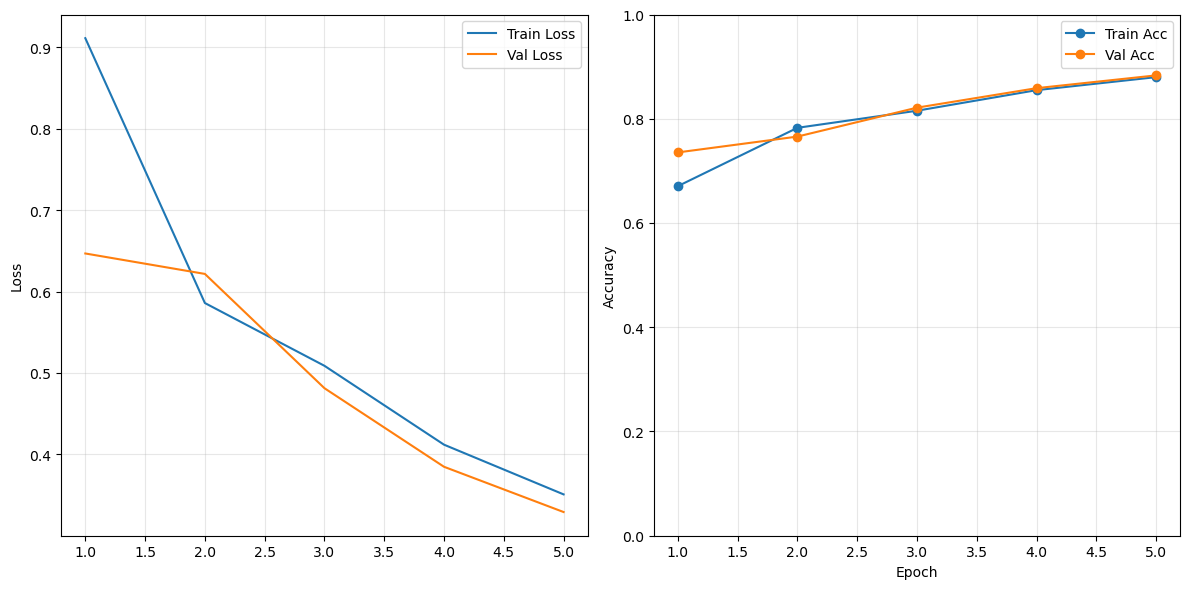

In [15]:
## Training ViT on BloodMNIST
# Remember to change `is_download` to True for the first run to download the data.

def train_vit_bloodmnist(num_epochs=5, device=None, batch_size=128,
                         img_size=96, lr=3e-4, weight_decay=0.05):
    import medmnist
    from medmnist import BloodMNIST
    import warnings
    warnings.filterwarnings("ignore", module=r"medmnist(\.|$)")

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    model = ViT(
        img_size=img_size, patch_size=16, in_chans=3,
        num_classes=8, embed_dim=192, depth=6, num_heads=3,
        mlp_ratio=4.0, drop=0.1, attn_drop=0.0
    ).to(device)

    # Data
    is_download = False  # set to True for first download
    transform = make_transforms(img_size)
    train_set = BloodMNIST(split='train', transform=transform, download=is_download)
    val_set   = BloodMNIST(split='val',   transform=transform, download=is_download)
    test_set  = BloodMNIST(split='test',  transform=transform, download=is_download)

    # Use num_workers=0 for Windows/Notebook stability; raise if your env supports it
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=256,      shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,      shuffle=False, num_workers=0, pin_memory=True)

    # Optim / Sched / Loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def evaluate(loader, model, criterion, device):
        model.eval()
        tot_loss, tot_correct, tot_n = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                y = y.squeeze().long()
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)
                tot_loss += loss.item() * x.size(0)
                tot_correct += (logits.argmax(1) == y).sum().item()
                tot_n += x.size(0)
        return tot_loss / tot_n, tot_correct / tot_n

    for epoch in range(1, num_epochs + 1):
        model.train()
        run_loss, run_correct, seen = 0.0, 0, 0

        for x, y in train_loader:
            y = y.squeeze().long()
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            bsz = x.size(0)
            run_loss += loss.item() * bsz
            run_correct += (logits.argmax(1) == y).sum().item()
            seen += bsz

        train_loss = run_loss / seen
        train_acc  = run_correct / seen

        val_loss, val_acc = evaluate(val_loader, model, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step()
        print(f"Epoch {epoch:02d} | loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
            f"acc {train_acc:.4f} | val_acc {val_acc:.4f}")

    # Plot training curve
    plot_history(history)

    return model, history

if __name__ == "__main__":
    train_vit_bloodmnist(num_epochs=5)


### Comparison with CNNs

On small- to medium-scale datasets—like MNIST or even ImageNet—Vision Transformers (ViTs) often trail strong CNNs like ResNets. This is because Transformers lack convolutional inductive biases such as translation invariance and locality. 

As model and data scale increase—e.g., training large ViTs on hundreds of millions of images—they surpass ResNets by a wide margin in image classification, showcasing superior scalability (Dosovitskiy et al., 2021). 

This shift reshaped vision architecture design and, with data-efficient training (DeiT; Touvron et al., 2021), ViTs became competitive on ImageNet as well. However, the quadratic cost of global self-attention limits vanilla Transformers on high-resolution inputs. Swin Transformers address this with hierarchical, shifted-window attention and convolution-like priors, delivering state-of-the-art results across tasks beyond classification (Liu et al., 2021).
